In [1]:
#IMPORTING THE LIBRARIES
import random as rd
import numpy as np 
import matplotlib.pyplot as plt 
import statistics as stat
import math
from math import *
from tqdm import tqdm
import pandas as pd
from scipy import integrate as intg
from scipy.stats import linregress
import warnings
import scipy.stats as si
np.seterr(divide='ignore', invalid='ignore')
import scipy.integrate as integrate
from scipy.special import gamma
import cmath
import scipy
warnings.filterwarnings('ignore')

## Lifted Heston ChF

In [2]:
#values for testing the following implemented functions
u, M = 2.3,100
#rough heston parameters, with alpha = H+0.5
rho,lamb,theta,nu,V0, alpha = -0.7,0.3,0.02,0.3,0.02, 0.6
S0,T = 100,1
n,rn = 20,2.5

In [11]:
rn = 1+10*(1/(2)**0.9)
H = 0.2
alpha = H+0.5
print('x: ', vec_x(2,rn,alpha))
print('c: ', vec_c(2,rn,alpha))

x:  [0.49291786 3.13439925]
c:  [0.36559155 0.63681029]


In [3]:
#function that creates the vector c according to the number 
#of factor n and the value of rn
def vec_c(n,rn,alpha):
    # c=[0]*n
    c = np.zeros(n)
    for i in range(n):
        c[i]=((np.power(rn,1-alpha)-1)/(gamma(alpha)*gamma(2-alpha)))*np.power(rn,(1-alpha)*(i+1-1-n/2))
    return(c)

#function that creates the vector x according to the number 
#of factor n and the value of rn
def vec_x(n,rn,alpha):
    # x=[0]*n
    x = np.zeros(n)
    for i in range(n):
        x[i]=(((1-alpha)*(np.power(rn,2-alpha)-1))/((2-alpha)*(np.power(rn,1-alpha)-1)))*np.power(rn,i+1-1-n/2)
    return(x)

def g0(t,c,x):
    a=0
    for i in range(len(c)):
        a=a+c[i]*(1-exp(-x[i]*t))/x[i]
    b=V0+lamb*theta*a
    return(b)

In [4]:
#Function that compute the characteristic function of the lifted heston model
def Ch_Lifted_Heston(u,S0,T,rho,lamb,theta,nu,V0,n,alpha,M):
    # u = argument of the ch. function
    # S0 = Initial price
    # rho,lamb,theta,nu,V0 = parameters of the Lifted Heston model
    # n = number of factors in the model
    # rN = constant used to define weights and mean-reversions
    # alpha = H+1/2 where H is the Hurst index
    # T = maturity
    # M = number of steps in the time discretization to calculate ch. function
    
    N = n
    if(n==20):
        rn=2.5
    else:
        rn=1+10*(1/(n)**0.9)
    # rn=1+10*(1/(n)**0.9)
    
    # to make sure we calculate ch. function and not moment gen. function
    omega=u
    i=complex(0,1)
    omega=i*omega
    
    # Definition of weights and mean reversions in the approximation
    c=vec_c(n,rn,alpha)
    x=vec_x(n,rn,alpha)
    
    # Time steps for the approximation of psi         
    delta = T/M;
    t=np.linspace(0,M,M+1)
    t = t * delta
    gammas=x
    # Function F
    F = lambda u_,v_ : 0.5*(u_**2-u_) + (rho*nu*u_-lamb)*v_ + .5*nu**2*v_**2
    # Iteration for approximation of psi - see Slide 87
    psi=np.zeros((M+1,N),dtype=complex)
    for k in range (1,M+1):
        for i in range(n):
            # psi[k,i] = (1/(1+delta*gammas[i]))*(psi[k-1,i]+delta*F(omega,c[i]*psi[k-1,i])*1)
            psi[k,i] = (1/(1+delta*gammas[i])) * (psi[k-1,i]+delta*F(omega, np.dot(c, psi[k-1,:]))*1)
    #creating th vector which gonna contain g0(t_k)
    g_0=np.zeros((1,M+1))
    for k in range(1,M+2):
        g_0[0,k-1]=g0(T-t[k-1],c,gammas)
    
    Y=np.zeros((1,M+1),dtype=complex)
    phi=0
    Y=F(omega, np.dot(c,psi.transpose()))*g_0
    # Trapezoid rule to calculate phi
    weights=np.ones(M+1)*delta
    weights[0]=delta/2
    weights[M]=delta/2
    phi=np.dot(weights,Y.transpose())
    
    # 没有考虑 U
    phi=np.exp(omega*np.log(S0)+phi)
    
    return phi

In [5]:
%%time
#test of the characteristic function
Ch_Lifted_Heston(u,S0,T,rho,lamb,theta,nu,V0,n,alpha,M)

CPU times: user 42.7 ms, sys: 27.4 ms, total: 70.1 ms
Wall time: 44.7 ms


array([-0.37885716-0.86925496j])

## Carr-Madan and Lewis formula (numerical integration without FFT)

没有考虑折现, 后续可以直接 multiply by exp(-rT)

In [6]:
#implementing the integral term in the call price function
#psi * exp(-iuk) in Jack eq(4.2.3)
def integral_term(u,S0,T,rho,lamb,theta, nu, V0,n,alpha, M, alpha2,K):
    i = complex(0,1)
    k = np.log(K)
    d = Ch_Lifted_Heston(u-(alpha2+1)*i,S0,T,rho,lamb,theta, nu, V0,n,alpha, M)
    term1 = np.exp(- i*u*k) * d
    term2 = (alpha2+i*u) * (alpha2+1+i*u)
    out = term1/term2
    # return out.real
    return np.real(out)

#implementing the call price function, jack eq(4.2.3)
def Call_Price_Lifted_Heston_CarrMadan(S0,K,T, rho,lamb,theta,nu,V0, n, alpha, M, alpha2, L):
    '''
    alpha2: dampening factor
    L: upper limit
    '''
    N = n
    k = np.log(K)
    # firsr term in (Jack 4.2.3)
    term1 = np.exp( - alpha2*k)/np.pi
    I = scipy.integrate.quad(lambda u:integral_term(u,S0,T,rho,lamb,theta, nu, V0,n,alpha, M, alpha2,K), 0,L)
    return term1*I[0]

def Call_Price_Lifted_Heston_Lewis(S0,K,T, rho,lamb,theta,nu,V0, n, alpha, M, L):
    '''
    See Yves
    '''
    k = np.log(K)
    # j = complex(0,1)
    integ = scipy.integrate.quad(lambda u: np.real(np.exp(-1j*u*k)*Ch_Lifted_Heston(u-0.5*1j,S0,T,rho,lamb,theta,nu,V0,n,alpha,M)) / (u**2 + 0.25), 0, L)
    return S0 - np.sqrt(S0*K) * integ[0] / np.pi

In [7]:
%%time
K = 0.9
n = 20
print('K: ', K, ', n: ', n)
print(Call_Price_Lifted_Heston_Lewis(1,K,1, -0.7, 0.3, 0.02, 0.3, 0.02, n,0.6, 300, 50))
print(Call_Price_Lifted_Heston_CarrMadan(1,K,1, -0.7, 0.3, 0.02, 0.3, 0.02, n,0.6, 300, 1.5,50))

K:  0.9 , n:  20
0.12030518593701689
0.12029390943831021
CPU times: user 22.4 s, sys: 39.1 s, total: 1min 1s
Wall time: 16.5 s


In [8]:
%%time
K = 1.1
n = 20
print('K: ', K, ', n: ', n)
print(Call_Price_Lifted_Heston_Lewis(1,K,1, -0.7, 0.3, 0.02, 0.3, 0.02, n,0.6, 300, 50))
print(Call_Price_Lifted_Heston_CarrMadan(1,K,1, -0.7, 0.3, 0.02, 0.3, 0.02, n,0.6, 300, 1.5,100))

K:  1.1 , n:  20
0.007278858525917031
0.007303792372916446
CPU times: user 21.3 s, sys: 40.5 s, total: 1min 1s
Wall time: 17.2 s


In [9]:
%%time
K = 0.9
n = 500
print('K: ', K, ', n: ', n)
print(Call_Price_Lifted_Heston_Lewis(1,K,1, -0.7, 0.3, 0.02, 0.3, 0.02, n,0.6, 300, 50))
print(Call_Price_Lifted_Heston_CarrMadan(1,K,1, -0.7, 0.3, 0.02, 0.3, 0.02, n,0.6, 300, 1.5,50))

K:  0.9 , n:  500
0.12025559586479717
0.12024354621169428
CPU times: user 6min 12s, sys: 2min 2s, total: 8min 14s
Wall time: 5min 46s


In [10]:
%%time
K_array = [0.9,1.0,1.1]
n_array = [20]

for K in K_array:
    for n in n_array:
        print('K: ', K, ', n: ', n)
        print(' Lewis: ', Call_Price_Lifted_Heston_Lewis(1,K,1, -0.7, 0.3, 0.02, 0.3, 0.02, n,0.6, 300, 50))
        print(' CarMd: ', Call_Price_Lifted_Heston_CarrMadan(1,K,1, -0.7, 0.3, 0.02, 0.3, 0.02, n,0.6, 300, 1.5,50))
        print()

K:  0.9 , n:  20
 Lewis:  0.12030518593701689
 CarMd:  0.12029390943831021

K:  1.0 , n:  20
 Lewis:  0.04574461948558739
 CarMd:  0.04574428863000907

K:  1.1 , n:  20
 Lewis:  0.007278858525917031
 CarMd:  0.007290600037969059

CPU times: user 58.8 s, sys: 1min 36s, total: 2min 35s
Wall time: 39 s


In [11]:
%%time
K_array = [0.9,1.0,1.1]
n_array = [1,3,5,10,20,50,100,200]

for K in K_array:
    for n in n_array:
        print('K: ', K, ', n: ', n)
        print(' Lewis: ', Call_Price_Lifted_Heston_Lewis(1,K,1, -0.7, 0.3, 0.02, 0.3, 0.02, n,0.6, 300, 50))
        print(' CarMd: ', Call_Price_Lifted_Heston_CarrMadan(1,K,1, -0.7, 0.3, 0.02, 0.3, 0.02, n,0.6, 300, 1.5,50))
        print()

K:  0.9 , n:  1
 Lewis:  0.12074376702429257
 CarMd:  0.12074411370730859

K:  0.9 , n:  3
 Lewis:  0.12100234756160877
 CarMd:  0.12100297798385472

K:  0.9 , n:  5
 Lewis:  0.1208693385701477
 CarMd:  0.12086773232400595

K:  0.9 , n:  10
 Lewis:  0.12064511832799751
 CarMd:  0.12063973101515574

K:  0.9 , n:  20
 Lewis:  0.12030518593701689
 CarMd:  0.12029390943831021

K:  0.9 , n:  50
 Lewis:  0.12035600934784407
 CarMd:  0.12034570714802487

K:  0.9 , n:  100
 Lewis:  0.12030826791844995
 CarMd:  0.12029714349516687

K:  0.9 , n:  200
 Lewis:  0.12027933515947897
 CarMd:  0.1202677059809727

K:  1.0 , n:  1
 Lewis:  0.053574767114797694
 CarMd:  0.053574835106142346

K:  1.0 , n:  3
 Lewis:  0.05032409142352867
 CarMd:  0.05032703660749637

K:  1.0 , n:  5
 Lewis:  0.04887878975851323
 CarMd:  0.04888238460236472

K:  1.0 , n:  10
 Lewis:  0.04743588452851433
 CarMd:  0.04743868456572093

K:  1.0 , n:  20
 Lewis:  0.04574461948558739
 CarMd:  0.04574428863000907

K:  1.0 , n:  50

## Lifted Heston MGF

### VIX by MGF differetiation

In [9]:
#Function that compute the characteristic function of the lifted heston model
def MgF_Lifted_Heston(u,S0,T,rho,lamb,theta,nu,V0,n,alpha,M):
    # u = argument of the mg. function
    # S0 = Initial price
    # rho,lamb,theta,nu,V0 = parameters of the Lifted Heston model
    # n = number of factors in the model
    # rN = constant used to define weights and mean-reversions
    # alpha = H+1/2 where H is the Hurst index
    # T = maturity
    # M = number of steps in the time discretization to calculate ch. function
    
    N = n
    if(n==20):
        rn=2.5
    else:
        rn=1+10*(1/(n)**0.9)
    
    omega=u
    
    # Definition of weights and mean reversions in the approximation
    c=vec_c(n,rn,alpha)
    x=vec_x(n,rn,alpha)
    
    # Time steps for the approximation of psi         
    delta = T/M;
    t=np.linspace(0,M,M+1)
    t = t * delta
    gammas=x
    # Function F
    F = lambda u_,v_ : 0.5*(u_**2-u_) + (rho*nu*u_-lamb)*v_ + .5*nu**2*v_**2
    # Iteration for approximation of psi - see Slide 87
    psi=np.zeros((M+1,N))
    for k in range (1,M+1):
        for i in range(n):
            psi[k,i] = (1/(1+delta*gammas[i])) * (psi[k-1,i]+delta*F(omega, np.dot(c, psi[k-1,:]))*1)
    #creating th vector which gonna contain g0(t_k)
    g_0=np.zeros((1,M+1))
    for k in range(1,M+2):
        g_0[0,k-1]=g0(T-t[k-1],c,gammas)
    
    Y=np.zeros((1,M+1))
    phi=0
    Y=F(omega, np.dot(c,psi.transpose()))*g_0
    # Trapezoid rule to calculate phi
    weights=np.ones(M+1)*delta
    weights[0]=delta/2
    weights[M]=delta/2
    phi=np.dot(weights,Y.transpose())
    
    # 没有考虑 U
    phi=np.exp(omega*np.log(S0)+phi)
    
    return phi

In [10]:
# values for testing the following implemented functions
u, M = -0.01, 200
# rough heston parameters, with alpha = H+0.5
rho,lamb,theta,nu,V0, alpha = -0.7,0.3,0.02,0.3,0.02, 0.6
S0, T = 1, 1/12
n = 2

In [11]:
%%time
# test of the Mg function
MgF_Lifted_Heston(u,S0,T,rho,lamb,theta,nu,V0,n,alpha,M)

CPU times: user 17.4 ms, sys: 5.83 ms, total: 23.3 ms
Wall time: 14.4 ms


array([1.00000842])

In [12]:
rn = 1+10*(1/(n)**0.9)
print(rn)
print('c: ', vec_c(n,rn,alpha))
print('x: ', vec_x(n,rn,alpha))

6.358867312681466
c:  [0.39571254 0.82933829]
x:  [0.50544458 3.21405504]


In [34]:
def grad_mgf(eps, S0,T,rho,lamb,theta,nu,V0,n,alpha,M):
    if(eps>0.01):
        eps = 0.01
    y2 = MgF_Lifted_Heston(eps,S0,T,rho,lamb,theta,nu,V0,n,alpha,M)
    y1 = MgF_Lifted_Heston(0.0,S0,T,rho,lamb,theta,nu,V0,n,alpha,M)
    return (y2-y1)/eps

def mgf_VIX(eps, S0,T,rho,lamb,theta,nu,V0,n,alpha,M):
    if(S0!=1.0):
        S0 = 1.0
    term1 = grad_mgf(eps, S0,T,rho,lamb,theta,nu,V0,n,alpha,M)
    VIX2 = -2/T * term1 * 100**2
    VIX = np.sqrt(VIX2)
    return VIX

In [33]:
%%time
mgf_VIX(0.0001, S0,T,rho,lamb,theta,nu,V0,n,alpha,10000)

CPU times: user 375 ms, sys: 236 ms, total: 611 ms
Wall time: 441 ms


array([14.14142185])

In [28]:
from utils import squared_VIX

### VIX by MGF with n=20

In [25]:
# values for testing the following implemented functions
M = 2.3, 1000
# rough heston parameters, with alpha = H+0.5
rho,lamb,theta,nu,V0, alpha = -0.7,0.3,0.02,0.3,0.02, 0.6
S0,T = 1, 1/12
n,rn = 20, 2.5

100%|██████████| 100/100 [00:17<00:00,  5.57it/s]

CPU times: user 26.1 s, sys: 44.5 s, total: 1min 10s
Wall time: 18 s


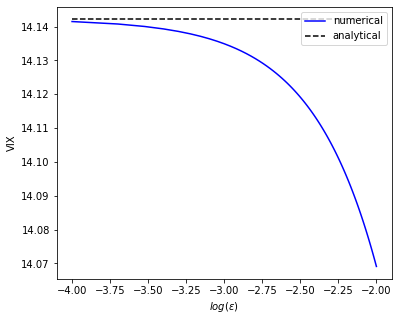

In [26]:
%%time
eps_ = np.cumsum(np.ones(100)*0.0001)
VIX_mgf = np.ones_like(eps_)
VIX_analytical = 14.14213562 ## compute from GPU code
for i in tqdm(range(len(eps_))):
    eps_i = eps_[i]
    VIX_mgf[i] = mgf_VIX(eps_i, 1.0,1/12,rho,lamb,theta,nu,V0,n,alpha,1000)

plt.figure(figsize=(6,5))
plt.plot(np.log10(eps_),VIX_mgf,color='blue',label='numerical')
plt.hlines(VIX_analytical,-4,-2,linestyle='dashed',color='black',label='analytical')
plt.xlabel('$log(\epsilon)$')
plt.ylabel('VIX')
plt.legend()

### VIX term structure by MGF

In [41]:
# rough heston parameters, with alpha = H+0.5
rho,lamb,theta,nu,V0, alpha = -0.7,0.3,0.02,0.3,0.01, 0.6
S0,T = 1, 1/12
n,rn = 20, 2.5

6it [00:10,  1.71s/it]

n:  20
CPU times: user 10.9 s, sys: 3.63 s, total: 14.5 s
Wall time: 10.3 s


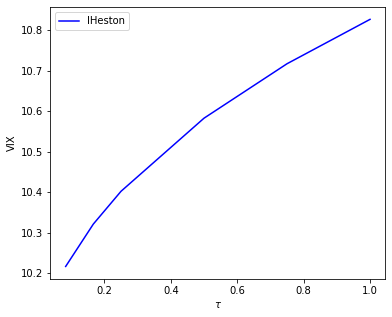

In [42]:
%%time
n = 20
tau_ = np.array([1/12,2/12,3/12,6/12,9/12,12/12])
VIX_mgf = np.ones_like(tau_)
for idx,tau_i in tqdm(enumerate(tau_)):
    VIX_mgf[idx] = mgf_VIX(0.0001, 1.0,tau_i,rho,lamb,theta,nu,V0,n,alpha,10000)

print('n: ', n)
plt.figure(figsize=(6,5))
plt.plot(tau_,VIX_mgf,color='blue',label='lHeston')
plt.xlabel('$\\tau$')
plt.ylabel('VIX')
plt.legend()

In [43]:
VIX_mgf

array([10.21634495, 10.3210765 , 10.40201612, 10.58268611, 10.71719163,
       10.82687594])

In [44]:
%%time
tau_ = np.array([1/12,2/12,3/12,6/12,9/12,12/12])

n = 5
VIX_mgf_5f = np.ones_like(tau_)
for idx,tau_i in tqdm(enumerate(tau_)):
    VIX_mgf_5f[idx] = mgf_VIX(0.0001, 1.0,tau_i,rho,lamb,theta,nu,V0,n,alpha,10000)
    
n = 10
VIX_mgf_10f = np.ones_like(tau_)
for idx,tau_i in tqdm(enumerate(tau_)):
    VIX_mgf_10f[idx] = mgf_VIX(0.0001, 1.0,tau_i,rho,lamb,theta,nu,V0,n,alpha,10000)
    
n = 25
VIX_mgf_25f = np.ones_like(tau_)
for idx,tau_i in tqdm(enumerate(tau_)):
    VIX_mgf_25f[idx] = mgf_VIX(0.0001, 1.0,tau_i,rho,lamb,theta,nu,V0,n,alpha,10000)
    
n = 50
VIX_mgf_50f = np.ones_like(tau_)
for idx,tau_i in tqdm(enumerate(tau_)):
    VIX_mgf_50f[idx] = mgf_VIX(0.0001, 1.0,tau_i,rho,lamb,theta,nu,V0,n,alpha,10000)

6it [00:03,  1.60it/s]
6it [00:04,  1.30it/s]
6it [00:11,  1.85s/it]
6it [00:22,  3.75s/it]

CPU times: user 44.3 s, sys: 9.78 s, total: 54.1 s
Wall time: 42 s


In [46]:
print(VIX_mgf_5f)
print(VIX_mgf_10f)
print(VIX_mgf_25f)
print(VIX_mgf_50f)

[10.11991973 10.20843272 10.2787935  10.43409827 10.54639411 10.6355185 ]
[10.15962916 10.25875854 10.33507298 10.50281782 10.62514282 10.72329926]
[10.19398294 10.29769842 10.37732518 10.55337165 10.68299717 10.78785135]
[10.20679981 10.31181614 10.39260847 10.57185946 10.70439821 10.81194283]


### VIX term structure by our explicit formula

see another ipynb file